### Reading data

In [1]:

from sclibrary.io.network_reader import read_B1_B2
import pandas as pd

path = "data/lastfm-dataset-1K"
scbuilder, triangles = read_B1_B2(f"{path}/B1-artist.csv", f"{path}/B2t-artist.csv")
sc = scbuilder.to_simplicial_complex(triangles=triangles)

flow_path = f"{path}/flow-artist.csv"
flow = (
        pd.read_csv(flow_path, delimiter=",", header=None).to_numpy().flatten()
    )

print("flow", len(flow))

Num. of nodes: 657
Num. of edges: 1997
Num. of triangles: 1276
Shape: (657, 1997, 1276)
Max Dimension: 2
flow 1997


In [2]:
import numpy as np
from numpy.linalg import norm

# Calculate initial divergence and curl
B1 = sc.incidence_matrix(rank=1)
B2 = sc.incidence_matrix(rank=2)
div_f = norm(B1 @ flow)
curl_f = norm(B2.T @ flow)
print("divergence_f:", div_f)
print("curl_f:", curl_f)

divergence_f: 1.4142135623730951
curl_f: 220.68076490713912


In [6]:
num_edges = len(sc.edges)
num_realizations = 50
#snr_db = np.arange(-12, 6.5, 0.5)
snr_db = np.arange(-12, 12.5, 12)
snr = 10 ** (snr_db / 10)
power_flow = np.linalg.norm(flow, 2)
power_noise = power_flow / snr / num_edges

In [4]:
# Initialize result arrays
div_noisy = np.zeros((len(snr), num_realizations))
curl_noisy = np.zeros((len(snr), num_realizations))
err_noisy = np.zeros((len(snr), num_realizations))

err_l2 = np.zeros((len(snr), num_realizations))
div_l2 = np.zeros((len(snr), num_realizations))
curl_l2 = np.zeros((len(snr), num_realizations))

err_l1_1 = np.zeros((len(snr), num_realizations))
div_l1_1 = np.zeros((len(snr), num_realizations))
curl_l1_1 = np.zeros((len(snr), num_realizations))

err_l1_2 = np.zeros((len(snr), num_realizations))
div_l1_2 = np.zeros((len(snr), num_realizations))
curl_l1_2 = np.zeros((len(snr), num_realizations))

err_l1_3 = np.zeros((len(snr), num_realizations))
div_l1_3 = np.zeros((len(snr), num_realizations))
curl_l1_3 = np.zeros((len(snr), num_realizations))

err_l1_4 = np.zeros((len(snr), num_realizations))
div_l1_4 = np.zeros((len(snr), num_realizations))
curl_l1_4 = np.zeros((len(snr), num_realizations))

err_l1_5 = np.zeros((len(snr), num_realizations))
div_l1_5 = np.zeros((len(snr), num_realizations))
curl_l1_5 = np.zeros((len(snr), num_realizations))

f_l2 = np.zeros((num_edges, len(snr), num_realizations))
f_l1_1 = np.zeros((num_edges, len(snr), num_realizations))
f_l1_2 = np.zeros((num_edges, len(snr), num_realizations))
f_l1_3 = np.zeros((num_edges, len(snr), num_realizations))
f_l1_4 = np.zeros((num_edges, len(snr), num_realizations))
f_l1_5 = np.zeros((num_edges, len(snr), num_realizations))

In [5]:
I = np.eye(num_edges)
L1l = sc.lower_laplacian_matrix(rank=1)

In [6]:
for i in range(len(snr)):
    print(i)
    for ii in range(num_realizations):
        noise = power_noise[i] * np.random.randn(num_edges, 1).flatten()
        f_noisy = flow + noise
    
        # div_noisy[i, ii] = norm(B1 @ f_noisy)
        # curl_noisy[i, ii] = norm(B2.T @ f_noisy)
        err_noisy[i, ii] = np.linalg.norm(f_noisy - flow) / np.linalg.norm(flow)
        
        # L2 denoising
        mu = 0.5
        H = np.linalg.inv(I + mu * L1l)
        f_l2[:, i, ii] = H @ f_noisy
        err_l2[i, ii] = norm(f_l2[:, i, ii] - flow) / norm(flow)
        div_l2[i, ii] = norm(B1 @ f_l2[:, i, ii])
        curl_l2[i, ii] = norm(B2.T @ f_l2[:, i, ii])

    print("err_l2", np.mean(err_l2[i, :]))

err_noisy_mean = np.mean(err_noisy, axis=1)
err_l2_mean = np.mean(err_l2, axis=1)

0
err_l2 0.303806691159758
1
err_l2 0.0194509165714284
2
err_l2 0.002977539972482728


In [8]:
err_l2_mean

array([0.30380669, 0.01945092, 0.00297754])

In [9]:
import cvxpy as cp

def solver(num_edges, f_noisy, mat):
    f_opt = cp.Variable(num_edges)
    mat = mat @ f_opt
    objective = cp.Minimize(1 * cp.norm(f_noisy - f_opt, p=2) + 0.5 * cp.norm(mat, p=1))
    prob = cp.Problem(objective)
    prob.solve()
    return f_opt

flow_norm = norm(flow)
B1_L1l = B1 @ L1l
L1l_2 = L1l @ L1l
B1_L1l_2 = B1 @ L1l_2

for i in range(len(snr)):
    print(i)
    for ii in range(num_realizations):
        noise = power_noise[i] * np.random.randn(num_edges, 1).flatten()
        f_noisy = flow + noise
        
        # L1 denoising
        f_opt_1 = solver(num_edges, f_noisy, B1)
        f_l1_1[:, i, ii] = f_opt_1.value
        err_l1_1[i, ii] = norm(f_l1_1[:, i, ii] - flow) / flow_norm
        div_l1_1[i, ii] = norm(B1 @ f_l1_1[:, i, ii])
        curl_l1_1[i, ii] = norm(B2.T @ f_l1_1[:, i, ii])

        # f_opt_2 = solver(num_edges, f_noisy, B1_L1l)
        # f_l1_2[:, i, ii] = f_opt_2.value
        # err_l1_2[i, ii] = norm(f_l1_2[:, i, ii] - flow) / flow_norm
        # div_l1_2[i, ii] = norm(B1 @ f_l1_2[:, i, ii])
        # curl_l1_2[i, ii] = norm(B2.T @ f_l1_2[:, i, ii])
    
        # f_opt_3 = solver(num_edges, f_noisy, B1_L1l_2)
        # f_l1_3[:, i, ii] = f_opt_3.value
        # err_l1_3[i, ii] = norm(f_l1_3[:, i, ii] - flow) / flow_norm
        # div_l1_3[i, ii] = norm(B1 @ f_l1_3[:, i, ii])
        # curl_l1_3[i, ii] = norm(B2.T @ f_l1_3[:, i, ii])
        
        # f_opt_4 = solver(num_edges, f_noisy, L1l)
        # f_l1_4[:, i, ii] = f_opt_4.value
        # err_l1_4[i, ii] = norm(f_l1_4[:, i, ii] - flow) / flow_norm
        # div_l1_4[i, ii] = norm(B1 @ f_l1_4[:, i, ii])
        # curl_l1_4[i, ii] = norm(B2.T @ f_l1_4[:, i, ii])
        
        # f_opt_5 = solver(num_edges, f_noisy, L1l_2)
        # f_l1_5[:, i, ii] = f_opt_5.value
        # err_l1_5[i, ii] = norm(f_l1_5[:, i, ii] - flow) / flow_norm
        # div_l1_5[i, ii] = norm(B1 @ f_l1_5[:, i, ii])
        # curl_l1_5[i, ii] = norm(B2.T @ f_l1_5[:, i, ii])
        
div_l1_1_mean = np.mean(div_l1_1, axis=1)
err_l1_1_mean = np.mean(err_l1_1, axis=1)

(CVXPY) May 29 09:37:58 PM: Encountered unexpected exception importing solver ECOS:
ImportError("dlopen(/Users/irtaza.hashmi@futurice.com/Desktop/Thesis/sc-graph-library/thesis_venv/lib/python3.11/site-packages/_ecos.cpython-311-darwin.so, 0x0002): tried: '/Users/irtaza.hashmi@futurice.com/Desktop/Thesis/sc-graph-library/thesis_venv/lib/python3.11/site-packages/_ecos.cpython-311-darwin.so' (mach-o file, but is an incompatible architecture (have 'x86_64', need 'arm64')), '/System/Volumes/Preboot/Cryptexes/OS/Users/irtaza.hashmi@futurice.com/Desktop/Thesis/sc-graph-library/thesis_venv/lib/python3.11/site-packages/_ecos.cpython-311-darwin.so' (no such file), '/Users/irtaza.hashmi@futurice.com/Desktop/Thesis/sc-graph-library/thesis_venv/lib/python3.11/site-packages/_ecos.cpython-311-darwin.so' (mach-o file, but is an incompatible architecture (have 'x86_64', need 'arm64'))")
(CVXPY) May 29 09:37:58 PM: Encountered unexpected exception importing solver SCS:
ImportError("dlopen(/Users/irtaza

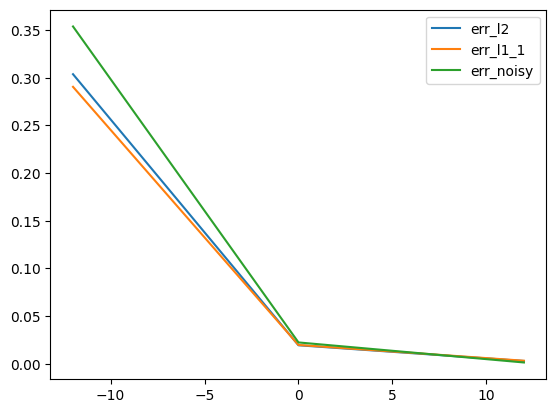

In [11]:
import matplotlib.pyplot as plt

plt.plot(snr_db, err_l2_mean, label="err_l2")
plt.plot(snr_db, err_l1_1_mean, label="err_l1_1")
plt.plot(snr_db, err_noisy_mean, label="err_noisy")
plt.legend()

In [26]:
ratio = np.arange(0.05, 1.05, 0.5)
corr_in_single = np.zeros((len(ratio), 100))
corr_out_single = np.zeros((len(ratio), 100))
div_in = np.zeros((len(ratio), 100))

err_l1_1 = np.zeros((len(ratio), 100))
corr_l1_1 = np.zeros((len(ratio), 100))
div_l1_1 = np.zeros((len(ratio), 100))
f_l1_1 = np.zeros((num_edges, len(ratio), 100))

In [27]:
ratio

array([0.05, 0.55])

In [28]:
import cvxpy as cp

I = np.eye(num_edges)

for i, r in enumerate(ratio):
    # the number of nonzero nodes
    M = int(num_edges * r)  
    for ii in range(50):
        mask = np.zeros(num_edges)
        mask[np.random.choice(num_edges, M, replace=False)] = 1
        sampling_matrix = np.diag(mask)
        
        # the labeled
        f_in = flow * mask
        corr_in_single[i, ii] = np.corrcoef(flow, f_in)[0, 1]
        
        # the filter method
        f_filtered1 = I @ f_in
        corr_out_single[i, ii] = np.corrcoef(flow, f_filtered1)[0, 1]
        div_in[i, ii] = np.linalg.norm(B1 @ f_in)
        
        f_opt_1 = cp.Variable(num_edges)
        objective = cp.Minimize(cp.norm(f_opt_1 - f_in) + 0.5 * cp.norm(B1 @ f_opt_1, 1))
        constraints = [sampling_matrix @ f_opt_1 == sampling_matrix @ f_in]
        prob = cp.Problem(objective, constraints)
        prob.solve()
        
        f_l1_1[:, i, ii] = f_opt_1.value
        err_l1_1[i, ii] = np.linalg.norm(f_l1_1[:, i, ii] - flow) / np.linalg.norm(flow)
        corr_l1_1[i, ii] = np.corrcoef(flow, f_l1_1[:, i, ii])[0, 1]
        div_l1_1[i, ii] = np.linalg.norm(B1 @ f_l1_1[:, i, ii])

In [31]:
error_mean = np.mean(err_l1_1, axis=1)
corr_mean = np.mean(corr_l1_1, axis=1)
div_mean = np.mean(div_l1_1, axis=1)
error_mean, corr_mean, div_mean

(array([0.47518292, 0.22648269]),
 array([0.14591562, 0.44286863]),
 array([0.82020142, 0.63257111]))